In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from collections import defaultdict
import math
import os
import librosa
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from glob import glob

In [2]:
val_path = '/home/willbo/data/dcase/val'
val_prediction_path = ''
pp_val_prediction_path = ''

test_path = '/home/willbo/data/dcase/test'
test_prediction_path = ''
pp_test_predcition_path = ''

In [3]:
#Create method that returns a dict where the keys are file names such as 'a1.wav'
#The elements of the dict are patch collections
#Create method which spit out plots

def get_dict(set_path, prediction, pp_prediction):
    
    annotation_y = 0.1
    pred_y = 0.4
    pp_pred_y = 0.7
    
    annotation_POS_color = 'black'
    annotation_UNK_color = 'red'
    pred_color = 'blue'
    pp_pred_color = 'orange'
    
    annotation_POS_patches = {}
    annotation_UNK_patches = {}
    prediction_patches = {}
    pp_prediction_patches = {}
    
    pred_dict = defaultdict(list)
    pp_pred_dict = defaultdict(list)
    
    pred_file = open(prediction, newline='')
    pp_pred_file = open(pp_prediction, newline='')
    
    pred_reader = csv.reader(pred_file, delimiter=',')
    pp_pred_reader = csv.reader(pp_pred_file, delimiter=',')
    
    predictions = []
    pp_predictions = []
    
    for e in pred_reader:
        predictions.append(e)
    for e in pp_pred_reader:
        pp_predictions.append(e)
        
    annotation_files = [file for file in glob(os.path.join(set_path, '*.csv'))]
    for a_file in annotation_files:
        
        reader = csv.reader(open(a_file, newline=''), delimiter=',')
        annotations = []
        for e in reader:
            annotations.append(e)
        
        key = annotations[1][0].replace('.csv', '.wav')
        annotation_POS_patches[key] = []
        annotation_UNK_patches[key] = []
        
        for e in annotations:
            if e[3] == 'POS':
                annotation_POS_patches[key].append(Rectangle([float(e[1]), annotation_y], float(e[2])-float(e[1]), 0.2, color=annotation_POS_color))
            if e[3] == 'UNK':
                annotation_UNK_patches[key].append(Rectangle([float(e[1]), annotation_y], float(e[2])-float(e[1]), 0.2, color=annotation_UNK_color))
        
    for i in range(1, len(predictions)):
        pred_dict[predictions[i][0]].append([predictions[i][1], predictions[i][2]])
    for i in range(1, len(pp_predictions)):
        pp_pred_dict[pp_predictions[i][0]].append([pp_predictions[i][1], pp_predictions[i][2]])
        
    for key in pred_dict:
        prediction_patches[key] = []
        for e in pred_dict[key]:
            prediction_patches[key].append(Rectangle([float(e[0]), pred_y], float(e[1])-float(e[0]), 0.2, color=pred_color))
        
    for key in pp_pred_dict:
        pp_prediction_patches[key] = []
        for e in pp_pred_dict[key]:
            pp_prediction_patches[key].append(Rectangle([float(e[0]), pp_pred_y], float(e[1])-float(e[0]), 0.2, color=pp_pred_color))
        
    return annotation_POS_patches, annotation_UNK_patches, prediction_patches, pp_prediction_patches

In [4]:
app, aup, pp, ppp = get_dict('/home/willbo/data/dcase/val',
         '/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/resnetBIG_semiall10_specaug_spl_lr5_650neg_l2/BEST_VAL_out.csv', 
         '/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/resnetBIG_semiall10_specaug_spl_lr5_650neg_l2/PP_BEST_VAL_out.csv')

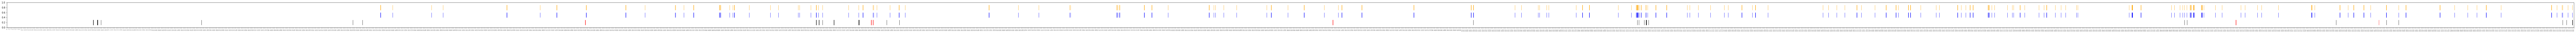

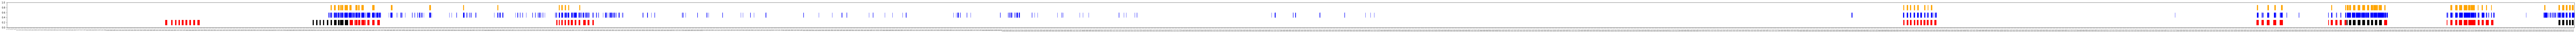

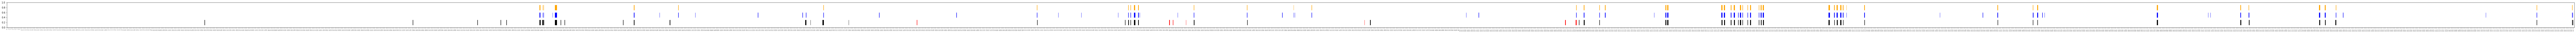

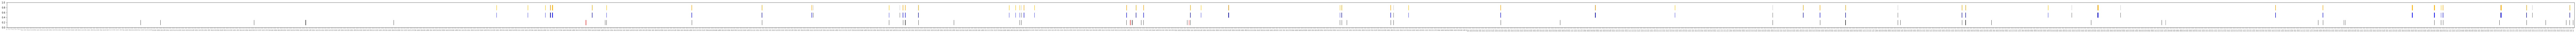

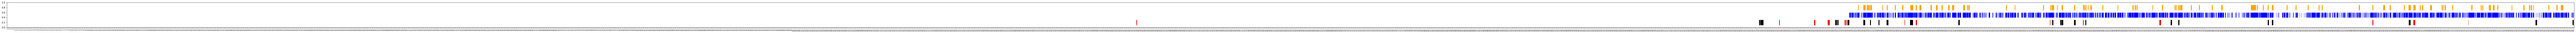

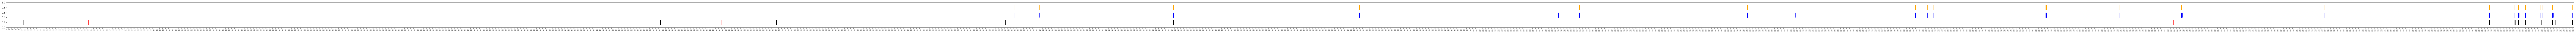

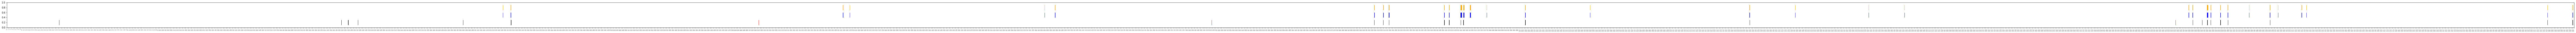

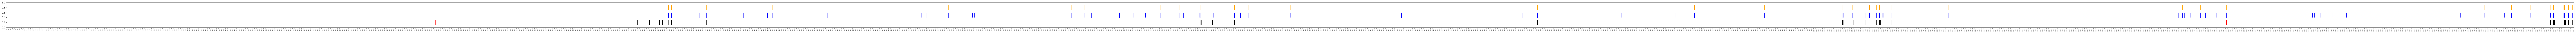

In [5]:
for key in app:

    fig = plt.figure(figsize=(200,2))
    patches = app[key]
    fig.gca().set_xlim(0, patches[-1].xy[0]+patches[-1].get_width()+1)
    fig.gca().set_ylim(0,1)
    fig.gca().add_collection(PatchCollection(patches, match_original=True))
    fig.gca().add_collection(PatchCollection(aup[key], match_original=True))
    fig.gca().add_collection(PatchCollection(pp[key], match_original=True))
    fig.gca().add_collection(PatchCollection(ppp[key], match_original=True))
    plt.xticks(np.arange(0, patches[-1].xy[0]+patches[-1].get_width()+1, 1))
    plt.xticks(rotation=90, fontsize=4)
    plt.savefig('predictionfigures/val/'+key.replace('.wav', '.pdf'), dpi=24000, bbox_inches='tight')

In [ ]:
#Do for test.

app, aup, pp, ppp = get_dict('/home/willbo/data/dcase/val',
         '/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/resnet_specaugment_spl_seed100/VAL_out.csv', 
         '/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/resnet_specaugment_spl_seed100/PP_VAL_out.csv')

In [3]:
'''
Process model prediction csv into a dict of binary valued arrays with file names as key
'''

def prediction_to_array(csv_path, set_path):
    
    increment = 1.0/tick_rate
    
    pred_dict = defaultdict(list)
    pred_dict_array = {}
    
    predictions_file = open(csv_path, newline='')
    predictions_reader = csv.reader(predictions_file, delimiter=',')
    predictions = []
    for e in predictions_reader:
        predictions.append(e)
    
    for i in range(1,len(predictions)):
        pred_dict[predictions[i][0]].append([predictions[i][1], predictions[i][2]])
    
    print('Processing prediction file: '+csv_path)
    for key in tqdm(pred_dict.keys()):

        #Go from onset offset predictions to array with binary elements indicating events
        index = 0.0
        i = 0
        prediction_array = np.zeros(math.floor(librosa.get_duration(filename=os.path.join(set_path, key))/increment))
        for event in pred_dict[key]:
            while index < float(event[0]):
                prediction_array[i] = 0
                index += increment
                i += 1
            while index < float(event[1]):
                prediction_array[i] = 1
                index += increment
                i += 1

        pred_dict_array[key] = prediction_array
        
    return pred_dict_array

In [4]:
d = prediction_to_array('/home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/resnet_specaugment_spl_seed100/PP_VAL_out.csv',
                       val_path)
d.keys()

Processing prediction file: /home/willbo/repos/soundscape-analysis/few_shot_learning/outputs/resnet_specaugment_spl_seed100/PP_VAL_out.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.32s/it]


dict_keys(['BUK5_20161101_002104a.wav', 'BUK4_20161011_000804.wav', 'a1.wav', 'BUK4_20171022_004304a.wav', 'BUK1_20181013_023504.wav', 'BUK5_20180921_015906a.wav', 'BUK1_20181011_001004.wav', 'n1.wav'])

In [5]:
def annotation_to_array(csv_path):

    increment = 1.0/tick_rate
    
    annotation_file = open(csv_path, newline='')
    annotations_reader = csv.reader(annotation_file, delimiter=',')
    annotations = []
    for e in annotations_reader:
        annotations.append(e)
        
    annotations_POS = []
    annotations_UNK = []
    
    for e in annotations:
        if e[3] == 'POS':
            annotations_POS.append([e[1], e[2]])
        elif e[3] == 'UNK':
            annotations_UNK.append([e[1], e[2]])
    
    annotations_array_POS = np.zeros(math.floor(librosa.get_duration(filename=csv_path.replace('.csv', '.wav'))/increment))
    annotations_array_UNK = np.zeros(math.floor(librosa.get_duration(filename=csv_path.replace('.csv', '.wav'))/increment))
    
    index = 0.0
    i = 0 
    
    for event in annotations_POS:
        while index < float(event[0]):
            annotations_array_POS[i] = 0
            index += increment
            i += 1
        while index < float(event[1]):
            annotations_array_POS[i] = 1
            index += increment
            i += 1
            
    index = 0.0
    i = 0
    
    for event in annotations_UNK:
        while index < float(event[0]):
            annotations_array_UNK[i] = 0
            index += increment
            i += 1
        while index < float(event[1]):
            annotations_array_UNK[i] = 1
            index += increment
            i += 1
                
    return annotations_array_POS, annotations_array_UNK

In [6]:
a_p, a_u = annotation_to_array('/home/willbo/data/dcase/val/a1.csv')

### TODO
Instead of having the visualization like this have rectangular bars at different y-values. Will be much more readable.
How do we take this step?

In [8]:
#Something like this again could be cool.
#Even better, fuck this shit with increments and an array of 1's and 0's.
#Just work with the events straightup. Should be easy to do right with the rectangle tool?

#krn = [1, -1]
#changes = np.convolve(filtered_array, krn)
#onsets = np.where(changes == 1)
#offsets = np.where(changes == -1)

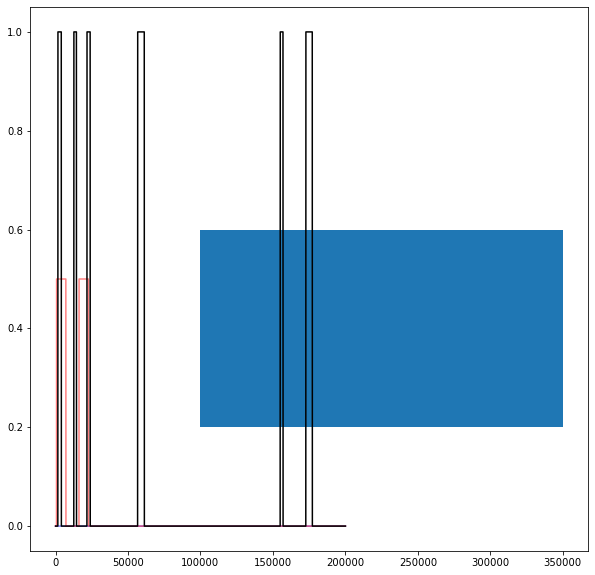

In [17]:
'''
We need to be able to see times and not tick indexes to make use of this I think.
'''
fig = plt.figure(figsize=(10,10))

plt.plot(a_p[1100000:1300000]*0.5, alpha=0.5, c='blue')
plt.plot(a_u[1100000:1300000]*0.5, c='red', alpha=0.5)
plt.plot(d['a1.wav'][1100000:1300000], c='black')
plt.gca().add_patch(Rectangle([100000,0.2], 250000, 0.4))

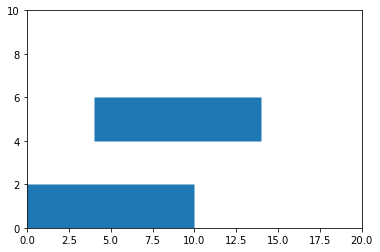

In [21]:
col = [Rectangle([0,0], 10, 2), Rectangle([4,4], 10, 2)]
p = PatchCollection(col, match_original=True)
fig = plt.figure()
#Seems that we manually need to set the lims
plt.gca().set_xlim(0,20)
plt.gca().set_ylim(0,10)
plt.gca().add_collection(p)

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(a_p[1100000:1300000]*0.5, alpha=0.5, c='blue')
plt.plot(a_u[1100000:1300000]*0.5, c='red', alpha=0.2)
plt.plot(d['a1.wav'][1100000:1300000], c='black')

In [ ]:
plt.plot(d[list(d.keys())[2]][200000:250000])

In [ ]:
predictions_file = open('postprocessing/clf_TEST_out.csv', newline='')
predictions_reader = csv.reader(predictions_file, delimiter=',')
predictions = []
for e in predictions_reader:
    predictions.append(e)

In [ ]:
rate = 3000
increment = 1.0/rate
pred_dict = defaultdict(list)
pred_dict_array = {}

for i in range(1,len(predictions)):
    pred_dict[predictions[i][0]].append([predictions[i][1], predictions[i][2]])
    
for key in tqdm(pred_dict.keys()):
        
    #Go from onset offset predictions to array with binary elements indicating events
    index = 0.0
    i = 0
    prediction_array = np.zeros(math.floor(librosa.get_duration(filename=os.path.join(test_path, key))/increment))
    for event in pred_dict[key]:
        while index < float(event[0]):
            prediction_array[i] = 0
            index += increment
            i += 1
        while index < float(event[1]):
            prediction_array[i] = 1
            index += increment
            i += 1
    
    pred_dict_array[key] = prediction_array

In [ ]:
plt.plot(pred_dict_array[list(pred_dict_array.keys())[2]][200000:250000])

In [ ]:
librosa.get_duration(filename=os.path.join(test_path, list(pred_dict_array.keys())[0]))